In [7]:
import os

import click
from os.path import  join, isdir
from plan import Plan
from action import Action
from utils import load_from_folder
from multiprocess import Pool


In [8]:
save_dir = './results/'
data_base_dir = '../datasets/'
domain = 'satellite'
results_dir = f"{save_dir}/{domain}/"   
source_dir = f"../datasets/gr_logistics/pickles" 
print('Domain dir:', source_dir)
os.makedirs(save_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)


Domain dir: ../datasets/gr_logistics/pickles


Data load

In [9]:
splits = {}
train_plans = load_from_folder(source_dir,["train_plans.pkl"])
train_plans = train_plans[0]
val_plans = load_from_folder(source_dir,["val_plans.pkl"])
val_plans = val_plans[0]
test_plans = load_from_folder(source_dir,["test_plans.pkl"])
test_plans = test_plans[0]

splits["train_plans"] = train_plans
splits["val_plans"] = val_plans
splits["test_plans"] = test_plans


train_plans.pkl loaded from ../datasets/gr_logistics/pickles
val_plans.pkl loaded from ../datasets/gr_logistics/pickles
test_plans.pkl loaded from ../datasets/gr_logistics/pickles


Data analysis

In [10]:
print(f"Train plans: {len(train_plans)}")
print(f"Val plans: {len(val_plans)}")
print(f"Test plans: {len(test_plans)}")

Train plans: 2544
Val plans: 318
Test plans: 318


In [11]:
for split in splits:
    print(f"{split}: Number of plans: {len(splits[split])}")        

train_plans: Number of plans: 2544
val_plans: Number of plans: 318
test_plans: Number of plans: 318


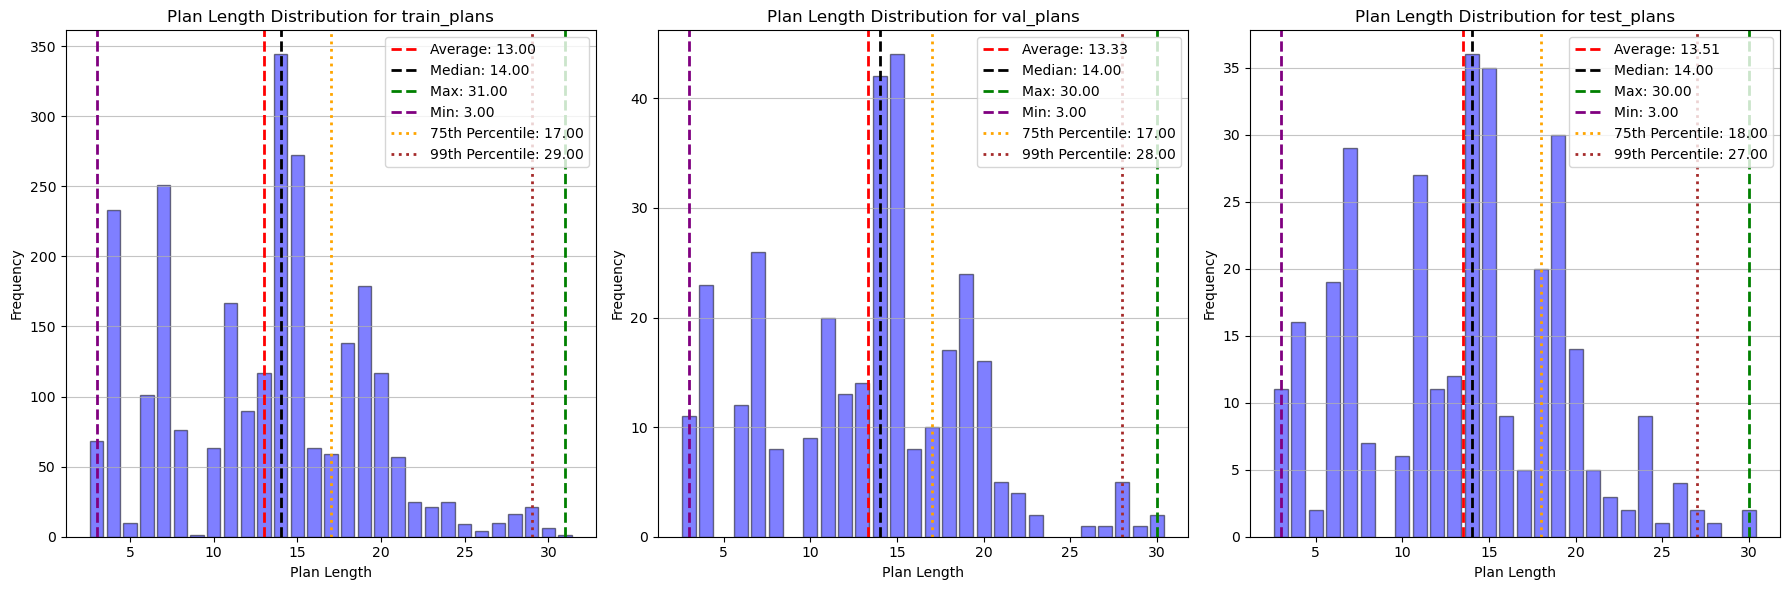

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(splits), figsize=(6 * len(splits), 6))
if len(splits) == 1:
    axs = [axs]
for ax, (split, plans) in zip(axs, splits.items()):
    plan_lengths = [len(plan.actions) for plan in plans]
    frequency = {}
    for length in plan_lengths:
        frequency[length] = frequency.get(length, 0) + 1
    avg_length_local = np.mean(plan_lengths)
    med_length_local = np.median(plan_lengths)
    max_length_local = np.max(plan_lengths)
    min_length_local = np.min(plan_lengths)
    perc75 = np.percentile(plan_lengths, 75)
    perc99 = np.percentile(plan_lengths, 99)
    ax.bar(frequency.keys(), frequency.values(), color='blue', alpha=0.5, edgecolor='black')
    ax.axvline(x=avg_length_local, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_length_local:.2f}')
    ax.axvline(x=med_length_local, color='black', linestyle='--', linewidth=2, label=f'Median: {med_length_local:.2f}')
    ax.axvline(x=max_length_local, color='green', linestyle='--', linewidth=2, label=f'Max: {max_length_local:.2f}')
    ax.axvline(x=min_length_local, color='purple', linestyle='--', linewidth=2, label=f'Min: {min_length_local:.2f}')
    ax.axvline(x=perc75, color='orange', linestyle=':', linewidth=2, label=f'75th Percentile: {perc75:.2f}')
    ax.axvline(x=perc99, color='brown', linestyle=':', linewidth=2, label=f'99th Percentile: {perc99:.2f}')
    ax.set_title(f"Plan Length Distribution for {split}")
    ax.set_xlabel("Plan Length")
    ax.set_ylabel("Frequency")
    ax.grid(axis='y', alpha=0.75)
    ax.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/{domain}/{domain}_combined_plan_length_distribution.jpeg")
plt.show()

In [14]:
for split, plans in splits.items():
    print(f"Plan {plans[0].plan_name} for {split}:")
    for action in plans[0].actions:
        print(f"    {action}")
    print()

Plan p037909_3 for train_plans:
    drive-truck tru3 pos11 pos22 cit5
    load-truck obj12 tru3 pos22
    drive-truck tru3 pos22 pos12 cit5
    unload-truck obj12 tru3 pos12
    drive-truck tru3 pos12 pos55 cit5
    load-truck obj66 tru3 pos55
    drive-truck tru3 pos55 apt1 cit5
    unload-truck obj66 tru3 apt1
    drive-truck tru1 pos13 apt4 cit3
    load-airplane obj66 apn6 apt1
    fly-airplane apn6 apt1 apt4
    unload-airplane obj66 apn6 apt4
    load-truck obj66 tru1 apt4
    drive-truck tru1 apt4 pos13 cit3
    unload-truck obj66 tru1 pos13

Plan p018946_4 for val_plans:
    drive-truck tru5 pos21 apt4 cit2
    load-truck obj33 tru1 pos13
    drive-truck tru1 pos13 apt3 cit5
    unload-truck obj33 tru1 apt3
    fly-airplane apn6 apt4 apt3
    load-airplane obj33 apn6 apt3
    fly-airplane apn6 apt3 apt4
    unload-airplane obj33 apn6 apt4
    load-truck obj33 tru5 apt4
    drive-truck tru5 apt4 pos44 cit2
    load-truck obj21 tru5 pos44
    drive-truck tru5 pos44 pos21 cit2
   

In [15]:
for split, plans in splits.items():
    for plan in plans[:3]:
        print(f"Goals {plan.goals}:")
        print()

Goals ['at obj12 pos12', 'at obj66 pos12']:

Goals ['at obj33 pos13', 'at obj88 pos33']:

Goals ['at obj99 pos21', 'at obj22 pos22']:

Goals ['at obj21 pos11', 'at obj12 pos55']:

Goals ['at obj13 pos11', 'at obj23 pos44']:

Goals ['at obj21 pos66', 'at obj23 pos44', 'at obj88 pos11']:

Goals ['at obj22 pos55', 'at obj13 pos66']:

Goals ['at obj77 pos55', 'at obj44 pos55']:

Goals ['at obj23 pos77', 'at obj55 pos44']:



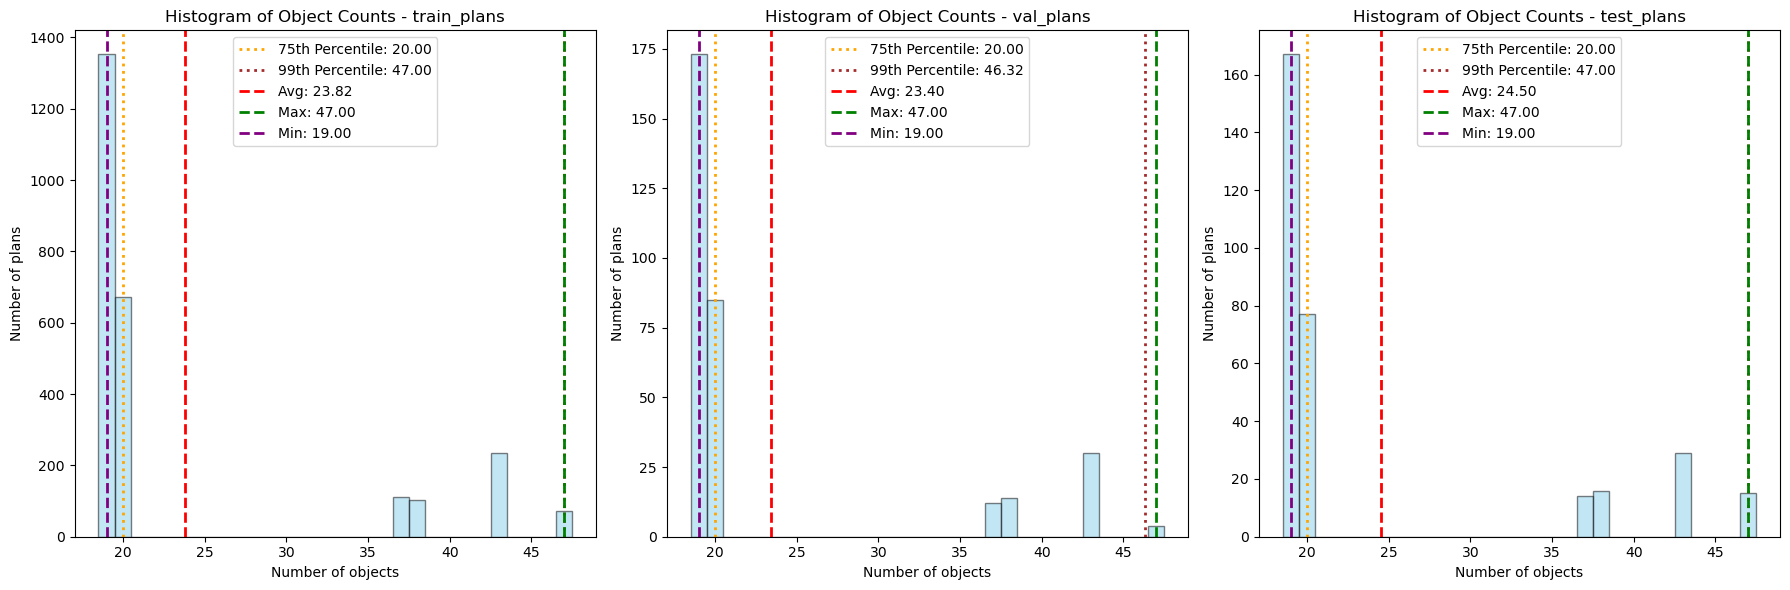

In [17]:
# counting plan init objects,
# how can i know all objects in the domain without the domain?
# try to explore the plan to find all objects involved
    
# create a combined figure with subplots for object count histograms
fig, axs = plt.subplots(1, len(splits), figsize=(6 * len(splits), 6))
if len(splits) == 1:
    axs = [axs]

for ax, (split, plans) in zip(axs, splits.items()):
    obj_numbers_list = []
    for plan in plans:
        obj_set = set()
        for text in plan.initial_state:
            for obj in text.split(" ")[1:]:
                obj_set.add(obj)
        for action in plan.actions:
                for obj in action.split(" ")[1:]:
                    obj_set.add(obj)
        obj_numbers_list.append(len(obj_set))
        
    bins = np.arange(min(obj_numbers_list), max(obj_numbers_list) + 2, 1)
    # bins = 20 #for logistics
    ax.hist(obj_numbers_list, bins=bins, color='skyblue', edgecolor='black', alpha=0.5, align='left')
    avg_val = np.mean(obj_numbers_list)
    max_val = np.max(obj_numbers_list)
    min_val = np.min(obj_numbers_list)
    perc75 = np.percentile(obj_numbers_list, 75)
    perc99 = np.percentile(obj_numbers_list, 99)
    ax.axvline(x=perc75, color='orange', linestyle=':', linewidth=2, label=f'75th Percentile: {perc75:.2f}')
    ax.axvline(x=perc99, color='brown', linestyle=':', linewidth=2, label=f'99th Percentile: {perc99:.2f}')
    ax.axvline(x=avg_val, color='red', linestyle='--', linewidth=2, label=f'Avg: {avg_val:.2f}')
    ax.axvline(x=max_val, color='green', linestyle='--', linewidth=2, label=f'Max: {max_val:.2f}')
    ax.axvline(x=min_val, color='purple', linestyle='--', linewidth=2, label=f'Min: {min_val:.2f}')

    ax.set_title(f"Histogram of Object Counts - {split}")
    ax.set_xlabel("Number of objects")
    ax.set_ylabel("Number of plans")
    ax.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/{domain}/{domain}_combined_obj_count_histogram.jpeg")
plt.show()